In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fastcore.xtras import load_pickle
from guacamol.utils.chemistry import is_valid

from gptchem.data import get_photoswitch_data
from gptchem.evaluator import evaluate_generated_smiles, evaluate_photoswitch_smiles_pred
from gptchem.settings import ONE_COL_GOLDEN_RATIO_HEIGHT_INCH, ONE_COL_WIDTH_INCH
from rdkit.Contrib.SA_Score.sascorer import calculateScore as calculate_sascore
from rdkit import Chem 

from scipy.stats import sem

import matplotx
import numpy as np 

from gptchem.plotsettings import *

%matplotlib inline

In [3]:
load_pickle('/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/out/20230204_112935/summary.pkl')

{'train_size': 92,
 'noise_level': 5.0,
 'num_samples': 100,
 'temperatures': [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0],
 'res_at_temp': [{'completions': {'choices': [' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=NN1)/N=N/C2=CC=C(C(F)(F)F)C=C2',
     ' CC1=C(C(C)=

In [4]:
def get_sa_scores(smiles):
    sa_scores = []
    for smiles in smiles:
        try:
            mol = Chem.MolFromSmiles(smiles)
            sa_scores.append(calculate_sascore(mol))
        except: 
            pass
    return sa_scores

In [5]:
from rdkit import Chem

In [6]:
all_res = glob("out/**/*.pkl")

In [7]:
res = load_pickle(all_res[0])

In [8]:
all_res[0]

'out/20230205_092340/summary.pkl'

In [9]:
from collections import defaultdict

In [10]:
def contains_azo(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # check if there is a N#N bond
    smarts = "[NX2]=N"
    return mol.HasSubstructMatch(Chem.MolFromSmarts(smarts))

In [11]:
compiled_res = []
generated_smiles = set()
generated_smiles_w_azos = set()

generated_smiles_w_azos_at_temp = defaultdict(set)
generated_smiles_at_temp = defaultdict(set)

for res_path in all_res:
    res = load_pickle(res_path)
    for temp_res in res["res_at_temp"]:
        try:
            metrics = {
                "noise_level": res["noise_level"],
                "temp": temp_res["temperature"],
                "frac_valid": temp_res["frac_valid"],
                "frac_unique": temp_res["frac_unique"],
                "frac_smiles_in_train": temp_res["frac_smiles_in_train"],
                "frac_smiles_in_pubchem": temp_res["frac_smiles_in_pubchem"],
                "kld": temp_res["kld"],
                "frechet_d": temp_res["frechet_d"],
                "frechet_score": temp_res["frechet_score"],
                "frac_contains_azo": sum([contains_azo(s) for s in temp_res["valid_smiles"]])
                / len(temp_res["valid_smiles"]),
            }
            valid_smiles = [s for s in temp_res["generated_smiles"] if is_valid(s)]
            generated_smiles.update(valid_smiles)
            v_w_azo = [s for s in temp_res["generated_smiles"] if is_valid(s) and contains_azo(s)]
            metrics['sa_score'] = np.mean(get_sa_scores(v_w_azo))
            generated_smiles_w_azos.update(v_w_azo)
            generated_smiles_w_azos_at_temp[temp_res["temperature"]].update(v_w_azo)

            v = [s for s in temp_res["generated_smiles"] if is_valid(s)]
            generated_smiles_at_temp[temp_res["temperature"]].update(v)

            for me, v in temp_res["e_pi_pi_star_metrics"].items():
                metrics["e_pi_pi_star_" + me] = v

            for me, v in temp_res["z_pi_pi_star_metrics"].items():
                metrics["z_pi_pi_star_" + me] = v

            
            compiled_res.append(metrics)

        except Exception:
            pass

In [12]:
contains_azo(list(generated_smiles)[5])

False

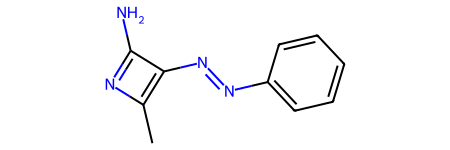

In [13]:
Chem.MolFromSmiles(list(generated_smiles)[0])

In [14]:
df = pd.DataFrame(compiled_res)

In [15]:
grouped = df.groupby(["temp"]).agg(["mean", "std", sem, 'count'])

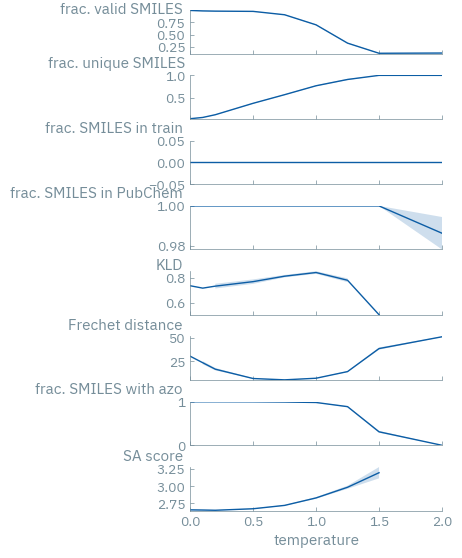

In [16]:


# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(8, 1, sharex="all", figsize=(ONE_COL_WIDTH_INCH, 2 * ONE_COL_WIDTH_INCH))
# plt.rcParams['axes.edgecolor']='#b0b0b0'
# plt.rcParams['axes.linewidth']=0.8
# plt.rcParams['xtick.color']='#b0b0b0'
# plt.rcParams['ytick.color']='#b0b0b0'
ax[0].plot(grouped.index, grouped["frac_valid"]["mean"], label="frac_valid")
ax[0].fill_between(
    grouped.index,
    grouped["frac_valid"]["mean"] - grouped["frac_valid"]["sem"],
    grouped["frac_valid"]["mean"] + grouped["frac_valid"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. valid SMILES", ax=ax[0])

ax[1].plot(grouped.index, grouped["frac_unique"]["mean"], label="frac_unique")
ax[1].fill_between(
    grouped.index,
    grouped["frac_unique"]["mean"] - grouped["frac_unique"]["sem"],
    grouped["frac_unique"]["mean"] + grouped["frac_unique"]["sem"],
    alpha=0.2,
)

matplotx.ylabel_top("frac. unique SMILES", ax=ax[1])

ax[2].plot(grouped.index, grouped["frac_smiles_in_train"]["mean"], label="frac_smiles_in_train")
ax[2].fill_between(
    grouped.index,
    grouped["frac_smiles_in_train"]["mean"] - grouped["frac_smiles_in_train"]["sem"],
    grouped["frac_smiles_in_train"]["mean"] + grouped["frac_smiles_in_train"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in train", ax=ax[2])

ax[3].plot(
    grouped.index, grouped["frac_smiles_in_pubchem"]["mean"], label="frac_smiles_in_pubchem"
)
ax[3].fill_between(
    grouped.index,
    grouped["frac_smiles_in_pubchem"]["mean"] - grouped["frac_smiles_in_pubchem"]["sem"],
    grouped["frac_smiles_in_pubchem"]["mean"] + grouped["frac_smiles_in_pubchem"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES in PubChem", ax=ax[3])

ax[4].plot(grouped.index, grouped["kld"]["mean"], label="kld")
ax[4].fill_between(
    grouped.index,
    grouped["kld"]["mean"] - grouped["kld"]["sem"],
    grouped["kld"]["mean"] + grouped["kld"]["sem"],
    alpha=0.2,
)

ylabel_top("KLD", ax=ax[4])

ax[5].plot(grouped.index, grouped["frechet_d"]["mean"], label="frechet_d")
ax[5].fill_between(
    grouped.index,
    grouped["frechet_d"]["mean"] - grouped["frechet_d"]["sem"],
    grouped["frechet_d"]["mean"] + grouped["frechet_d"]["sem"],
    alpha=0.2,
)

ylabel_top("Frechet distance", ax=ax[5])

ax[6].plot(grouped.index, grouped["frac_contains_azo"]["mean"], label="frechet_score")
ax[6].fill_between(
    grouped.index,
    grouped["frac_contains_azo"]["mean"] - grouped["frac_contains_azo"]["sem"],
    grouped["frac_contains_azo"]["mean"] + grouped["frac_contains_azo"]["sem"],
    alpha=0.2,
)

ylabel_top("frac. SMILES with azo", ax=ax[6])


ax[7].plot(grouped.index, grouped["sa_score"]["mean"], label="frechet_score")
ax[7].fill_between(
    grouped.index,
    grouped["sa_score"]["mean"] - grouped["sa_score"]["sem"],
    grouped["sa_score"]["mean"] + grouped["sa_score"]["sem"],
    alpha=0.2,
)

ylabel_top("SA score", ax=ax[7])


ax[-1].set_xlabel("temperature", labelpad=4)

# for a in ax:
#     a.spines['top'].set_visible(False)
#     a.spines['right'].set_visible(False)
#     #a.spines['left'].set_bounds((1, len(my_range)))
#     a.set_xlim(0,2)
#     # add some space between the axis and the plot
#     a.spines['left'].set_position(('outward', 8))
#     a.spines['bottom'].set_position(('outward', 5))

for i in range(1,8):
    ax[i].set_title('  \n      ')
fig.subplots_adjust(hspace=0.5)
#fig.tight_layout()
fig.savefig("photoswitch_random_smiles_metrics.pdf", bbox_inches="tight")

KeyError: 'z_pi_pi_star_novel_mean_absolute_error'

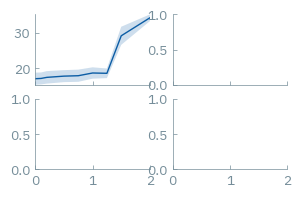

In [17]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    2, 2, sharex="all", figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH)
)

ax[0][0].plot(
    grouped.index,
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[0][0].fill_between(
    grouped.index,
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
    - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
    grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
    + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
    alpha=0.2,
)

ax[0][1].plot(
    grouped.index,
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[0][1].fill_between(
    grouped.index,
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
    - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
    grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
    + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[0][0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                - grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
                grouped["z_pi_pi_star_mean_absolute_error"]["mean"]
                + grouped["z_pi_pi_star_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["z_pi_pi_star_mean_absolute_error"]["mean"].mean(),
    ),
)




range_frame(
    ax[0][1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                - grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
                grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"]
                + grouped["z_pi_pi_star_novel_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["z_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
    ),
)
# ylabel_top("MAE / nm", ax=ax[0][0])

ax[0][0].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")
ax[0][1].hlines(11.616605626696359, 0, 2, color="k", linestyle="--")
# ax[0].set_ylim(8, 35)

ax[1][0].plot(
    grouped.index,
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[1][0].fill_between(
    grouped.index,
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
    - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
    grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
    + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
    alpha=0.2,
)

range_frame(
    ax[1][0],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                - grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
                grouped["e_pi_pi_star_mean_absolute_error"]["mean"]
                + grouped["e_pi_pi_star_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["e_pi_pi_star_mean_absolute_error"]["mean"].mean(),
    ),
)


ax[1][1].plot(
    grouped.index,
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"],
    label="e_pi_pi_star_metrics",
)
ax[1][1].fill_between(
    grouped.index,
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
    - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
    grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
    + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
    alpha=0.2,
)



range_frame(
    ax[1][1],
    grouped.index,
    np.nan_to_num(
        np.stack(
            [
                grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                - grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
                grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"]
                + grouped["e_pi_pi_star_novel_mean_absolute_error"]["sem"],
            ]
        ).flatten(),
        grouped["e_pi_pi_star_novel_mean_absolute_error"]["mean"].mean(),
    ),
)



# ylabel_top("MAE / nm", ax=ax[1][0])

ax[1][0].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")
ax[1][1].hlines(14.38998132190228, 0, 2, color="k", linestyle="--")


ax[0][0].set_title('all')
ax[0][1].set_title('novel')

ylabel_top(r'$Z$ isomer MAE / nm', ax[0][0], x_pad=0.1)
ylabel_top(r'$E$ isomer MAE / nm', ax[1][0], x_pad=0.1)

fig.text(0.4, -0.04, "temperature")
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
fig.savefig("random_photoswitch_constrain_matches.pdf", bbox_inches="tight")

## Visualize

In [103]:
import numpy as np
import tmap as tm
from faerun import Faerun
from mhfp.encoder import MHFPEncoder
from rdkit.Chem import AllChem
from tqdm import tqdm

In [104]:
import os
import shutil

In [105]:
def make_figure(temp):
    path = f"plots_all/{temp}"
    os.makedirs(path, exist_ok=True)
    enc = MHFPEncoder()
    lf = tm.LSHForest(2048, 128)
    train_data = get_photoswitch_data()
    train_smiles = train_data["SMILES"].values
    all_smiles = set(train_smiles) | generated_smiles_at_temp[temp]

    fps = []
    labels = []

    for smiles in tqdm(all_smiles):
        mol = AllChem.MolFromSmiles(smiles)
        fps.append(tm.VectorUint(enc.encode_mol(mol, min_radius=0)))
        labels.append(smiles in train_smiles)

    lf.batch_add(fps)
    lf.index()
    cfg = tm.LayoutConfiguration()
    cfg.k = 100
    cfg.sl_extra_scaling_steps = 6
    cfg.sl_repeats = 2
    cfg.mmm_repeats = 2
    cfg.node_size = 2
    x, y, s, t, _ = tm.layout_from_lsh_forest(lf, config=cfg)

    f = Faerun(
        clear_color="#FFFFFF",
        coords=False,
        view="free",
        impress='made with <a href="http://tmap.gdb.tools" target="_blank">tmap</a><br />and <a href="https://github.com/reymond-group/faerun-python" target="_blank">faerun</a>',
    )
    f.add_scatter(
        f"Photoswitches",
        {
            "x": x,
            "y": y,
            "c": labels,
            "labels": all_smiles,
        },
        colormap="Set1",
        categorical=True,
        shader="sphere",
        has_legend=True,
        point_scale=5,
        legend_labels=[(1, "in database"), (0, "not in database")],
        max_point_size=5000,
    )
    f.add_tree(
        "Photoswitches_tree",
        {
            "from": s,
            "to": t,
        },
        point_helper="Photoswitches",
    )
    f.plot("Photoswitches", template="smiles")

    shutil.copy("Photoswitches.html", path)

In [111]:
import pubchempy as pcp

In [114]:
cmpd = pcp.get_compounds("CN1C(=NC2=CC=CCN2)N=CC=N1", smiles="CN1C(=NC2=CC=CCN2)N=CC=N1", namespace="SMILES")[0]

pubchempy.Compound

In [106]:
for temp in [0, 0.1, 0.2, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0]:
    make_figure(temp)

100%|██████████| 406/406 [00:03<00:00, 128.29it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 406/406 [00:03<00:00, 126.85it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 410/410 [00:03<00:00, 126.42it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 487/487 [00:03<00:00, 129.72it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 647/647 [00:05<00:00, 128.28it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 884/884 [00:05<00:00, 150.26it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 833/833 [00:05<00:00, 162.41it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 694/694 [00:03<00:00, 190.85it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

100%|██████████| 762/762 [00:03<00:00, 192.95it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [107]:
make_figure(1.5)

100%|██████████| 694/694 [00:03<00:00, 180.50it/s]


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/experiments/05_inverse/photoswitch/random/Photoswitches.html

In [108]:
color1 = '#dcffdc'
color2 = '#dcdcdc'

In [109]:
unique_at_075 = generated_smiles_w_azos_at_temp[1.5] - set(get_photoswitch_data()["SMILES"].values)
unique_train =set(get_photoswitch_data()["SMILES"].values) -generated_smiles_w_azos_at_temp[1.5]

In [110]:

import random

lines = []

for i, v in enumerate(list(unique_at_075)):
    v = v.split()[0]
    lines.append(f"{v}\t{color1}")

for i, v in enumerate(list(unique_train)):
    v = v.split()[0]
    lines.append(f"{v}\t{color2}")

for line in random.sample(lines, 150):
    print(line)

CC1=CC=C(/N=N/C2=CC=CS2)C=C1	#dcdcdc
O=C(O)C(C=C1)=CC=C1N=NC2=NNC=C2	#dcdcdc
CC1=NOC(C)=C1/N=N/C2=CC(O)=CC=C2	#dcdcdc
CN1C=C(C(C)=NN1)N=NC2=CC=CC=C2	#dcffdc
O=[N+]([O-])C1=CC=CC(/N=N/C2=CC([N+]([O-])=O)=CC=C2)=C1	#dcdcdc
[H]C(C=C1)=CC=C1N=NC2=NNC=C2	#dcdcdc
Sc1[nH]nc(n1)N=Nc1c(c2ccccc2)n(c2c1cccc2)C	#dcdcdc
FC1=CC=CC(F)=C1/N=N/C2=C(F)C=CC=C2F	#dcdcdc
C1(/N=N/C2=CC=NN2)=CC=NN1	#dcdcdc
[H]C7=CC([N+]([O-])=O)=CC(C#N)=C7/N=N/C8=CC(OC)=C(C=C8)N(CC)CC	#dcdcdc
CC1=NOC(C)=C1/N=N/C2=CC=C(C)C=C2	#dcdcdc
[N-]=[N+]=NCC(C=C1)=CC2=C1CCC3=C(/N=N\2)C=C(CN=[N+]=[N-])C=C3	#dcdcdc
OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C(C)C=C%41S%40)C=C%38	#dcdcdc
CN(C)C(C=C1)=CC=C1/N=N/C2=CC=C(N(C)C)C=C2	#dcdcdc
CC1=NOC(C)=CC(N)=C1/N=N/C2=CC=CC=C2	#dcffdc
CC1=C(/N=N/C2=CC=CS2)C=C1	#dcffdc
CC1=C(C(C)=NO1)/N=N/C2=CC(OC)=C=C2	#dcffdc
CC1=NOC(C)=C1/N=N/C2=CC(C)=CC=CC2	#dcffdc
OC%11=C%12N=CC=CC%12=C(/N=N/C%13=NC(CC(OCC)=O)=CS%13)C=C%11	#dcdcdc
CC(C=C(N(CCC#N)CCO)C=C1)=C1/N=N/C2=CC(C(F)(F)F)=CC=C2	#dcdcdc
CC%13=C(N%14C

## Find some candidates for further investigation